In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer


In [33]:
df = pd.read_csv("Cornescu_Darius_new_features.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Condition2,SalePrice,LotArea_m^2,Price_per_m^2,ZoningScore,SubClassScore,LotAreaNorm,PDI,Price_per_m^2_norm,EVI
0,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,Norm,145000,780.385200,185.805676,0.795605,0.105263,0.033186,0.359777,0.168856,0.344162
1,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,Norm,178000,728.080811,244.478356,0.795605,0.315789,0.030555,0.422145,0.226847,0.415263
2,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,Norm,85000,815.409631,104.242085,0.795605,0.157895,0.034948,0.376095,0.088239,0.314380
3,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,Norm,175000,668.901600,261.622935,0.795605,0.263158,0.027577,0.405462,0.243793,0.413210
4,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,Norm,127000,464.515000,273.403442,0.795605,0.263158,0.017294,0.402378,0.255437,0.419031


In [34]:
target = "SalePrice"
X = df.drop(columns=[target])
Y = df[target]

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MSSubClass          1168 non-null   int64  
 1   MSZoning            1168 non-null   object 
 2   LotFrontage         951 non-null    float64
 3   LotArea             1168 non-null   int64  
 4   Street              1168 non-null   object 
 5   Alley               74 non-null     object 
 6   LotShape            1168 non-null   object 
 7   LandContour         1168 non-null   object 
 8   Utilities           1168 non-null   object 
 9   LotConfig           1168 non-null   object 
 10  LandSlope           1168 non-null   object 
 11  Neighborhood        1168 non-null   object 
 12  Condition1          1168 non-null   object 
 13  Condition2          1168 non-null   object 
 14  SalePrice           1168 non-null   int64  
 15  LotArea_m^2         1168 non-null   float64
 16  Price_

In [36]:
numerical_col = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_col = X.select_dtypes(include=["object"]).columns.tolist()

print("Numerical columns:", numerical_col)
print("Categorical columns:", categorical_col)

Numerical columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'LotArea_m^2', 'Price_per_m^2', 'ZoningScore', 'SubClassScore', 'LotAreaNorm', 'PDI', 'Price_per_m^2_norm', 'EVI']
Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']


In [37]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)   

In [39]:
pipeline.fit(X_train, Y_train)
Y_pred = pipeline.predict(X_test)

In [40]:
mae = mean_absolute_error(Y_test, Y_pred)
r2  = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print("MAE:", mae)
print("R2:", r2)
print("MSE:", mse)

MAE: 13328.589743589744
R2: 0.8517648265475003
MSE: 958164028.034188


# SHAP - integration


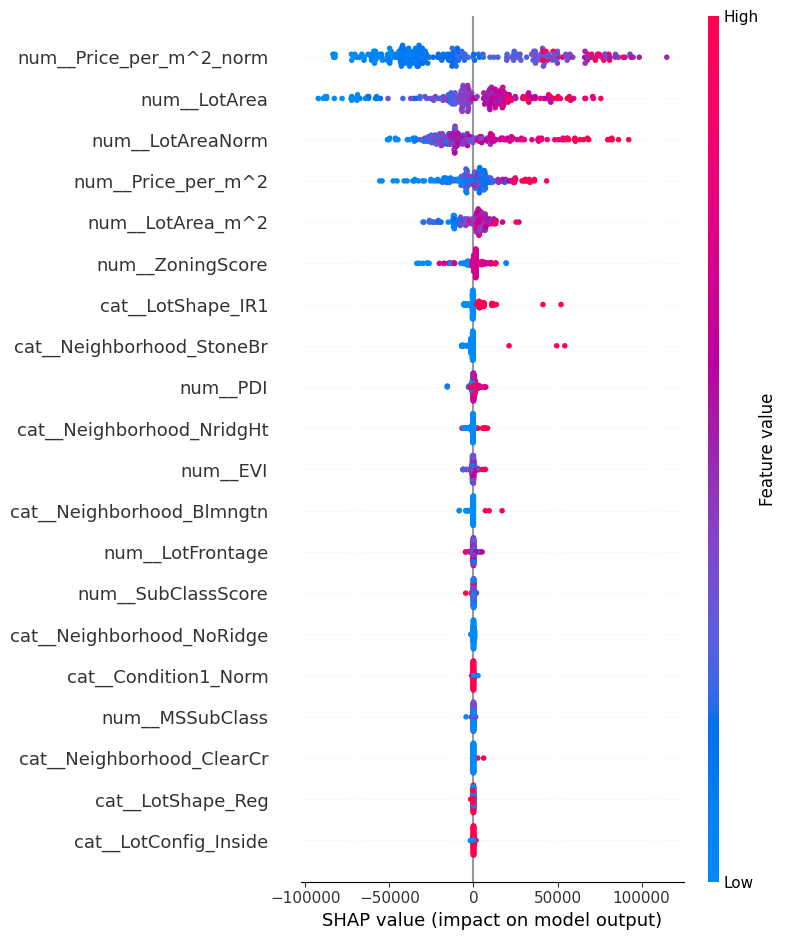

In [45]:
preprocessor = pipeline.named_steps['preprocessor']
regression = pipeline.named_steps['model']

X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed = X_test_preprocessed.toarray()

explainer = shap.Explainer(regression)
shap_values = explainer.shap_values(X_test_preprocessed)

shap.summary_plot(shap_values, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

We can observe that `Price_per_m^2_norm` and `LotArea` have the strongest impact on the predicted sale price.

Higher values of `Price_per_m^2_norm` tend to significantly increase the estimated price, indicating that properties with a higher cost per square meter are systematically evaluated as more expensive. 

In contrast, large `LotArea` values have a mixed effect: for some properties, a larger land area increases the price, while in other cases it may indicate less central or less desirable locations, which lowers the price. This variability explains the wide spread of SHAP values around zero.

Additionally, categorical features from the `Neighborhood` and `LotShape` groups show localized effects, suggesting that both the geographical area and the shape of the lot influence property valuation.



In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])


In [ ]:
param_grid = {
    "preprocessor__num__imputer__n_neighbors": [2, 3, 5, 7, 9],
    "model__max_depth": [None, 5, 10, 15, 20],
    "model__min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, Y_train)

print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_

Best parameters: {'model__max_depth': None, 'model__min_samples_split': 5, 'preprocessor__num__imputer__n_neighbors': 3}


In [ ]:
Y_pred = best_model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
r2  = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print("Tuned MAE:", mae)
print("Tuned R2:", r2)
print("Tuned MSE:", mse)

Tuned MAE: 13265.633903133903
Tuned R2: 0.8378695657299027
Tuned MSE: 1047980356.8142213
